# Feature Extraction

The purpose of this notebook is extract a variety of machine learning features from the historical AFL match data, to be used in predicting the outcomes of future matches.

As noted in the [introduction](1_introduction.ipynb#Feature-Extraction "Section: Feature Extraction"), for reasons of data scarcity we shall typically consider marginal models, i.e. models predicting the match outcome (win, draw or loss) of a given team versus any abitrary opponent.

Prior to a given match, one set of useful historical statistics includes the number of games previously won, drawn and lost by each team. Also of importance are the numbers of points scored by and against each team. Similarly, the league ranking of each team might be predictive of future outcomes. In general, any such summary statistics might be useful for match prediction.

## Load the data

In [1]:
import os
from datetime import datetime as parse_datetime

import pandas as pd

In [2]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [3]:
date_fn = lambda s: parse_datetime.strptime(s, "%a %d-%b-%Y %I:%M %p")
df_matches['timestamp'] = df_matches.datetime.apply(date_fn)

In [4]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_goals2,against_behinds2,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,edge_type,timestamp
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,6,7,9,7,10,6,192,4,lost-to,1990-03-31 14:10:00
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,1,5,6,3,6,5,104,4,lost-to,1990-03-31 14:10:00
2,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,3,4,4,4,3,4,89,0,defeated,1990-03-31 14:10:00
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,2,4,1,3,2,4,60,0,defeated,1990-03-31 14:10:00
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,4,5,1,3,3,2,74,0,defeated,1990-03-31 19:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,2,7,3,4,5,4,82,4,lost-to,2022-07-16 17:30:00
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,4,2,3,2,2,5,85,4,lost-to,2022-07-16 19:25:00
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,3,1,2,2,3,0,77,0,defeated,2022-07-17 13:10:00
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,3,2,2,3,3,3,69,0,defeated,2022-07-17 14:50:00


In [5]:
all_teams = sorted(set(df_matches.for_team) | set(df_matches.against_team))
print(all_teams)

['Adelaide', 'Brisbane Bears', 'Brisbane Lions', 'Carlton', 'Collingwood', 'Essendon', 'Fitzroy', 'Footscray', 'Fremantle', 'Geelong', 'Gold Coast', 'Greater Western Sydney', 'Hawthorn', 'Kangaroos', 'Melbourne', 'North Melbourne', 'Port Adelaide', 'Richmond', 'St Kilda', 'Sydney', 'West Coast', 'Western Bulldogs']


## End-of-season statistics

As noted in the [introduction](1_introduction.ipynb#Backoff-and-smoothing "Section: Backoff and smoothing"), for reasons of data scarcity we 
typically need to modify our marginal models, using backoff and smoothing of the counts of various events. In particular, when predicting the outcomes of matches in a given season, it might be useful to use the overall team results from the previous season as prior information.

Note that we shall here consider all matches in each season, which includes both the minor rounds and the finals rounds (with team eliminations). 
Also note that the number of teams in the AFL might change from season to season, due to
mergers of existing teams and the addition of new teams.
Hence, the total number of games played per team per season will typically vary. 

### Initialise data structures

In order to summarise seasonal data, we need to know the season and each team in the league for that season.
Since the number of teams varies over time, we should also keep track of the number of teams.

In [6]:
def get_season_matches(df_matches, season):
    """
    Obtains a single season of matches.
    """
    return df_matches[df_matches.season == season]

In [7]:
def init_team_features(df_season_matches):
    """
    Initialises the team features for one season of matches.
    """
    if len(df_season_matches) == 0:
        season = 0
        teams = []
    else:
        season = df_season_matches.season.values[0]
        teams = sorted(set(df_season_matches.for_team) | set(df_season_matches.against_team))
    num_teams = len(teams)
    return pd.DataFrame({
        'season': [season] * num_teams,
        'team': teams,
        'teams': [num_teams] * num_teams
    })

In [8]:
all_seasons = sorted(set(df_matches.season))

In [9]:
d_features = dict()
for season in all_seasons:
    df_season_matches = get_season_matches(df_matches, season)
    d_features[season] = init_team_features(df_season_matches)

In [10]:
d_features[all_seasons[0]]

,season,team,teams
0,1990,Brisbane Bears,14
1,1990,Carlton,14
2,1990,Collingwood,14
3,1990,Essendon,14
4,1990,Fitzroy,14
5,1990,Footscray,14
6,1990,Geelong,14
7,1990,Hawthorn,14
8,1990,Melbourne,14
9,1990,North Melbourne,14


### Numbers of wins, draws and losses

The relative strength of a team's offense can be indirectly measured by the number of wins, and the relative weakness of its defense can be measured by the number of losses. If we count a draw as a half-win and a half-loss, then we can also compute the proportion of adjusted wins, which estimates the probability of the team
winning against an arbitrary opponent.

In [11]:
set(df_matches.edge_type)

{'defeated', 'drew-with', 'lost-to'}

In [12]:
FOR_WON = 'defeated'
AGAINST_WON = 'lost-to'

In [13]:
from collections import defaultdict

In [14]:
def add_wins_features(df_features, df_season_matches):
    """
    Adds season-total wins, draws and losses for each team.
    """
    # Count team -> win, draw, loss
    WIN, DRAW, LOSS = range(3)
    data = defaultdict(lambda : [0, 0, 0])
    for match in df_season_matches.itertuples():
        # Check outcome of 'for' team vs 'against' team
        outcome = match.edge_type
        if outcome == FOR_WON:
            data[match.for_team][WIN] += 1
            data[match.against_team][LOSS] += 1
        elif outcome == AGAINST_WON:
            data[match.for_team][LOSS] += 1
            data[match.against_team][WIN] += 1
        else:
            data[match.for_team][DRAW] += 1
            data[match.against_team][DRAW] += 1
    # Add features
    df_features['wins'] = [data[t][WIN] for t in df_features.team]
    df_features['draws'] = [data[t][DRAW] for t in df_features.team]
    df_features['losses'] = [data[t][LOSS] for t in df_features.team]
    adj_wins = df_features.wins + 0.5 * df_features.draws
    adj_losses = df_features.losses + 0.5 * df_features.draws
    df_features['wins_ratio'] = adj_wins / (adj_wins + adj_losses)

In [15]:
all_seasons = sorted(set(df_matches.season))
for season in all_seasons:
    df_season_matches = get_season_matches(df_matches, season)
    add_wins_features(d_features[season], df_season_matches)

In [16]:
d_features[all_seasons[0]]

,season,team,teams,wins,draws,losses,wins_ratio
0,1990,Brisbane Bears,14,4,0,18,0.181818
1,1990,Carlton,14,11,0,11,0.500000
2,1990,Collingwood,14,19,1,6,0.750000
3,1990,Essendon,14,18,0,7,0.720000
4,1990,Fitzroy,14,7,0,15,0.318182
5,1990,Footscray,14,12,0,10,0.545455
6,1990,Geelong,14,8,0,14,0.363636
7,1990,Hawthorn,14,14,0,9,0.608696
8,1990,Melbourne,14,17,0,7,0.708333
9,1990,North Melbourne,14,12,0,10,0.545455


Note that one of the reasons for collecting per-season features is to help predict the next season.
Therefore, let us see how strong this predictive capability might be.

In [17]:
prev_wins_ratios = []
cur_wins_ratios = []
it = iter(all_seasons)
prev_season = next(it)
prev_features = d_features[prev_season]
for cur_season in it:
    cur_features = d_features[cur_season]
    for team_features in cur_features.itertuples():
        team = team_features.team
        ind = prev_features.team == team
        if not any(ind):
            # Team has merged or changed name
            continue
        cur_wins_ratios.append(team_features.wins_ratio)
        prev_wins_ratio = prev_features.loc[ind, 'wins_ratio'].values[0]
        prev_wins_ratios.append(prev_wins_ratio)
    prev_features = cur_features

In [18]:
print(prev_wins_ratios[0:10])
print(cur_wins_ratios[0:10])

[0.18181818181818182, 0.5, 0.75, 0.72, 0.3181818181818182, 0.5454545454545454, 0.36363636363636365, 0.6086956521739131, 0.7083333333333334, 0.5454545454545454]
[0.13636363636363635, 0.36363636363636365, 0.5681818181818182, 0.5652173913043478, 0.18181818181818182, 0.4318181818181818, 0.68, 0.76, 0.5833333333333334, 0.5454545454545454]


In [19]:
import matplotlib.pyplot as plt

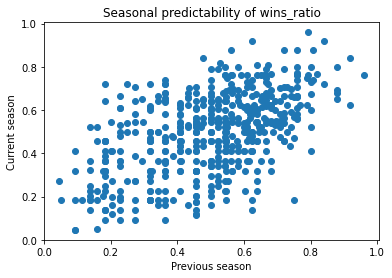

In [20]:
plt.plot(prev_wins_ratios, cur_wins_ratios, 'o')
plt.title("Seasonal predictability of wins_ratio")
plt.xlabel("Previous season")
plt.ylabel("Current season")
plt.show()

As noted in the 
[introduction](1_introduction.ipynb#Temporal-heterogeneity "Section: Temporal heterogeneity"), 
teams change in composition and strength over time, especially season by season, so we should not necessarily expect a strong predictive effect.
As expected, there is a large amount of variability from one season to the next. However, overall there does seem to be a positive linear correlation. Hence, we conclude that the predictive effect is weak but does exist.

### Points for and against 

The relative strength of a team's offense can also be indirectly measured by the number of points scored by the team, and the relative weakness of its defense can be measured by the number of points scored against it.
The proportion of points scored by a team against all opponents estimates the probability of the team
winning against an arbitrary opponent.

In [21]:
def add_points_features(df_features, df_season_matches):
    """
    Adds season-total number of points scored by each 
    team and against each team.
    """
    # Count team -> points_for, points_against
    TEAM_SCORED, OPPONENT_SCORED = range(2)
    data = defaultdict(lambda : [0, 0])
    for match in df_season_matches.itertuples():
        for_team = match.for_team
        for_score = match.for_total_score
        against_team = match.against_team
        against_score = match.against_total_score
        data[for_team][TEAM_SCORED] += for_score
        data[for_team][OPPONENT_SCORED] += against_score
        data[against_team][TEAM_SCORED] += against_score
        data[against_team][OPPONENT_SCORED] += for_score
    # Add features
    df_features['for'] = [data[t][TEAM_SCORED] for t in df_features.team]
    df_features['against'] = [data[t][OPPONENT_SCORED] for t in df_features.team]
    _wins = df_features['for']
    _losses = df_features.against
    df_features['points_ratio'] = _wins / (_wins + _losses)

In [22]:
for season in all_seasons:
    df_season_matches = get_season_matches(df_matches, season)
    add_points_features(d_features[season], df_season_matches)

In [23]:
d_features[all_seasons[0]]

,season,team,teams,wins,draws,losses,wins_ratio,for,against,points_ratio
0,1990,Brisbane Bears,14,4,0,18,0.181818,1733,2426,0.416687
1,1990,Carlton,14,11,0,11,0.500000,2277,2187,0.510081
2,1990,Collingwood,14,19,1,6,0.750000,2798,2077,0.573949
3,1990,Essendon,14,18,0,7,0.720000,2742,2079,0.568762
4,1990,Fitzroy,14,7,0,15,0.318182,1874,2389,0.439597
5,1990,Footscray,14,12,0,10,0.545455,2016,2031,0.498147
6,1990,Geelong,14,8,0,14,0.363636,2248,2398,0.483857
7,1990,Hawthorn,14,14,0,9,0.608696,2478,2075,0.544257
8,1990,Melbourne,14,17,0,7,0.708333,2512,2260,0.526404
9,1990,North Melbourne,14,12,0,10,0.545455,2519,2210,0.532671


In [24]:
def combine_season_features(d_features):
    """
    Concatenates all per-season features into a combined DataFrame.
    """
    return pd.concat([
        d_features[season] for season in sorted(d_features.keys())
    ])

The objective measure of a team's success is given by the proportion of wins per season.
One predictive measure of success is the points ratio, $R=\frac{F}{F+A}$, where $F$ is the total number of points scored by (i.e. 'for') the team, and $A$ is the number of points scored against the team.
It is of interest to note that this is exactly equivalent to the logistic model $R=\sigma(x)$
with feature $x=\ln\frac{F}{A}$ and logistic-sigmoid function $\sigma(x)\doteq (1+e^{-x})^{-1}$.

Let us see how this is correlated with the wins ratio.

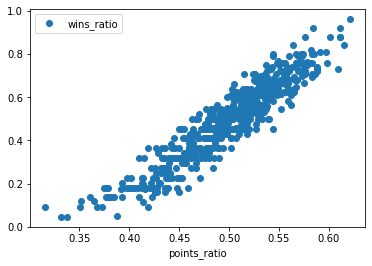

In [25]:
df_seasonal = combine_season_features(d_features)
ax = df_seasonal.plot(x='points_ratio', y='wins_ratio', style='o')

It looks like there is a strong linear correlation, which is a good thing. 
However, we have actually cheated because each match win implies that the team's 'for' score must be 
higher than its 'against' score, and vice versa.
Note that aggregation blurs this relationship somewhat - for example, a close win combined with a big loss looks like a loss. Thus, the points ratio should still be a reasonable predictor.

We now test this predictive ability across seasons, expecting a much weaker effect (i.e. higher variability).

In [26]:
prev_points_ratios = []
cur_points_ratios = []
cur_wins_ratios = []
it = iter(all_seasons)
prev_season = next(it)
prev_features = d_features[prev_season]
for cur_season in it:
    cur_features = d_features[cur_season]
    for team_features in cur_features.itertuples():
        team = team_features.team
        ind = prev_features.team == team
        if not any(ind):
            # Team has merged or changed name
            continue
        cur_wins_ratios.append(team_features.wins_ratio)
        cur_points_ratios.append(team_features.points_ratio)
        prev_points_ratio = prev_features.loc[ind, 'points_ratio'].values[0]
        prev_points_ratios.append(prev_points_ratio)
    prev_features = cur_features

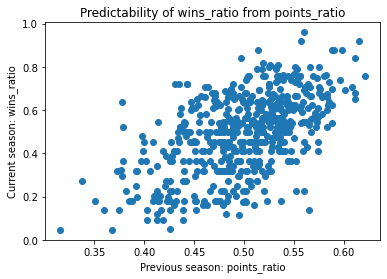

In [27]:
plt.plot(prev_points_ratios, cur_wins_ratios, 'o')
plt.title("Predictability of wins_ratio from points_ratio")
plt.xlabel("Previous season: points_ratio")
plt.ylabel("Current season: wins_ratio")
plt.show()

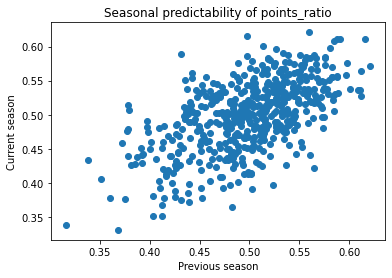

In [28]:
plt.plot(prev_points_ratios, cur_points_ratios, 'o')
plt.title("Seasonal predictability of points_ratio")
plt.xlabel("Previous season")
plt.ylabel("Current season")
plt.show()

As expected, there is a lot of variability from season to season. However, the points ratio in one season does seem to be positively correlated with both the wins ratio and points ratio in the next season.

### League ranking

The league rankings give a measure of the relative strength of each team, with a higher rank (i.e. smaller rank index) indicating a stronger team, and a lower rank (i.e. larger rank index) indicating a weaker team.

In practice, the league rankings are computed round by round only during the minor rounds. At the end of the minor rounds, the top-half ranked teams enter into the finals rounds, with team match-ups dictated by ranking. 
However, since we have chosen to consider all matches, from both the minor rounds and finals rounds, then we shall compute an overall ranking at the end of each season.

Also note that, since the number of teams varies per season, so too does the maximum rank. Thus, we should compute an adjusted rank that is comparable across different seasons. For convenience, we map the top-ranking team to a score of 1.0 and the bottom-ranking team to a score of 0.0.

In [29]:
def add_rank_features(df_features):
    """
    Adds end-of-season rankings for each team.
    Requires both 'add_wins_features()' and
    'add_points_features()' to have been called first.
    """
    df = df_features.copy()
    df['match_points'] = 4 * df.wins + 2 * df.draws
    df['percentage'] = 100 * df['for'] / df.against
    df.sort_values(['match_points', 'percentage'], ascending=False, inplace=True)
    df['rank'] = range(1, len(df) + 1)
    df.sort_values('team', inplace=True)
    ranks = df['rank'].values
    df_features['rank'] = ranks
    num_teams = df_features.teams.values[0]
    scale = -1.0 / (num_teams - 1)
    df_features['rank_score'] = scale * (ranks - 1) + 1

In [30]:
for season in all_seasons:
    add_rank_features(d_features[season])

In [31]:
d_features[all_seasons[0]]

,season,team,teams,wins,draws,losses,wins_ratio,for,against,points_ratio,rank,rank_score
0,1990,Brisbane Bears,14,4,0,18,0.181818,1733,2426,0.416687,14,0.000000
1,1990,Carlton,14,11,0,11,0.500000,2277,2187,0.510081,8,0.461538
2,1990,Collingwood,14,19,1,6,0.750000,2798,2077,0.573949,1,1.000000
3,1990,Essendon,14,18,0,7,0.720000,2742,2079,0.568762,2,0.923077
4,1990,Fitzroy,14,7,0,15,0.318182,1874,2389,0.439597,12,0.153846
5,1990,Footscray,14,12,0,10,0.545455,2016,2031,0.498147,7,0.538462
6,1990,Geelong,14,8,0,14,0.363636,2248,2398,0.483857,10,0.307692
7,1990,Hawthorn,14,14,0,9,0.608696,2478,2075,0.544257,5,0.692308
8,1990,Melbourne,14,17,0,7,0.708333,2512,2260,0.526404,4,0.769231
9,1990,North Melbourne,14,12,0,10,0.545455,2519,2210,0.532671,6,0.615385


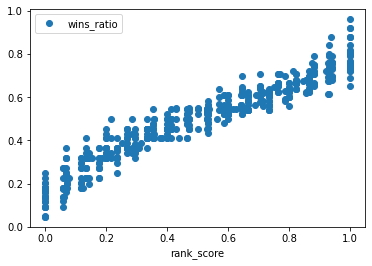

In [32]:
df_seasonal = combine_season_features(d_features)
ax = df_seasonal.plot(x='rank_score', y='wins_ratio', style='o')

It would appear that within the same season, the rank score is highly correlated with the wins ratio.
This is not surprising, since the rank is mostly determined from the number of wins (4 match points each)
and draws (2 match points each).

In [33]:
prev_rank_scores = []
cur_rank_scores = []
cur_wins_ratios = []
it = iter(all_seasons)
prev_season = next(it)
prev_features = d_features[prev_season]
for cur_season in it:
    cur_features = d_features[cur_season]
    for team_features in cur_features.itertuples():
        team = team_features.team
        ind = prev_features.team == team
        if not any(ind):
            # Team has merged or changed name
            continue
        cur_wins_ratios.append(team_features.wins_ratio)
        cur_rank_scores.append(team_features.rank_score)
        prev_rank_score = prev_features.loc[ind, 'rank_score'].values[0]
        prev_rank_scores.append(prev_rank_score)
    prev_features = cur_features

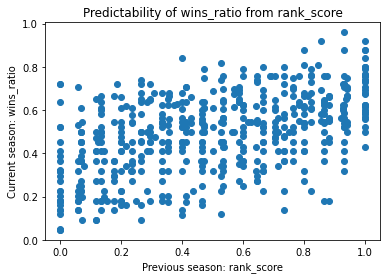

In [34]:
plt.plot(prev_rank_scores, cur_wins_ratios, 'o')
plt.title("Predictability of wins_ratio from rank_score")
plt.xlabel("Previous season: rank_score")
plt.ylabel("Current season: wins_ratio")
plt.show()

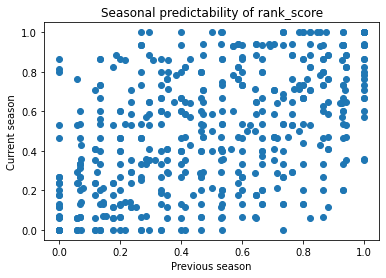

In [35]:
plt.plot(prev_rank_scores, cur_rank_scores, 'o')
plt.title("Seasonal predictability of rank_score")
plt.xlabel("Previous season")
plt.ylabel("Current season")
plt.show()

In contrast to the within-season effect, it appears that
the rank score does not have any predictive power across seasons.

### Prestige scores

We now take each match in a given season as an edge in a graph with the teams as vertices. From this graph we may compute various analytics, including vertex scores.
Here we compute the flow prestige scores 
(see [Appendix B](B_graph_analytics.ipynb#Steady-state-flow-scores "Section: Steady-state flow scores")).

Note, however, that the prestige scores depend upon the number of teams, and hence are not directly comparable
across seasons. We therefore also compute renormalised prestige scores 
(see 
[Appendix B](B_graph_analytics.ipynb#Probabilitistic-modelling "Section: Probabilitistic modelling"))
to estimate the probability of each team winning against an arbitrary opponent.

In [36]:
import numpy as np
from numpy.linalg import eig

In [37]:
def add_prestige_features(df_features, df_season_matches):
    """
    Adds prestige scores for each team, computed from
    the graph of all matches in the season.
    """
    # Compute the adjacency matrix A of the 'wins' graph,
    # i.e. A_ij = points scored by team i against team j.
    teams = { t: i for i, t in enumerate(df_features.team) }
    num_teams = len(teams)
    A = np.zeros((num_teams, num_teams), dtype=int)
    # Also keep track of the matrix N of games played,
    # i.e. N_ij = #games played between teams i and j.
    N = np.zeros((num_teams, num_teams), dtype=int)
    for match in df_season_matches.itertuples():
        i = teams[match.for_team]
        j = teams[match.against_team]
        A[i, j] += match.for_total_score
        N[i, j] += 1
        A[j, i] += match.against_total_score
        N[j, i] += 1
    # Compute the flow-rate matrix R of the graph,
    # where each rate is the avg. points per match.
    N[N == 0] = 1  # prevent div 0
    R = A / N
    s = np.sum(R, axis=0)
    np.fill_diagonal(R, -s)
    # Find eigenvector with zero eigenvalue
    w, v = eig(R)
    idx = np.where(np.abs(w) <= 1e-6)[0][0]
    p = np.real(v[:, idx])
    p /= np.sum(p)
    df_features['prestige'] = p
    p_bar = (1 - p) / (num_teams - 1)
    df_features['adj_prestige'] = p / (p + p_bar)

In [38]:
for season in all_seasons:
    df_season_matches = get_season_matches(df_matches, season)
    add_prestige_features(d_features[season], df_season_matches)

In [39]:
d_features[all_seasons[0]]

,season,team,teams,wins,draws,losses,wins_ratio,for,against,points_ratio,rank,rank_score,prestige,adj_prestige
0,1990,Brisbane Bears,14,4,0,18,0.181818,1733,2426,0.416687,14,0.000000,0.049030,0.401289
1,1990,Carlton,14,11,0,11,0.500000,2277,2187,0.510081,8,0.461538,0.073333,0.507091
2,1990,Collingwood,14,19,1,6,0.750000,2798,2077,0.573949,1,1.000000,0.096696,0.581871
3,1990,Essendon,14,18,0,7,0.720000,2742,2079,0.568762,2,0.923077,0.096170,0.580403
4,1990,Fitzroy,14,7,0,15,0.318182,1874,2389,0.439597,12,0.153846,0.057674,0.443097
5,1990,Footscray,14,12,0,10,0.545455,2016,2031,0.498147,7,0.538462,0.069013,0.490749
6,1990,Geelong,14,8,0,14,0.363636,2248,2398,0.483857,10,0.307692,0.066317,0.480076
7,1990,Hawthorn,14,14,0,9,0.608696,2478,2075,0.544257,5,0.692308,0.081022,0.534050
8,1990,Melbourne,14,17,0,7,0.708333,2512,2260,0.526404,4,0.769231,0.075421,0.514669
9,1990,North Melbourne,14,12,0,10,0.545455,2519,2210,0.532671,6,0.615385,0.080525,0.532384


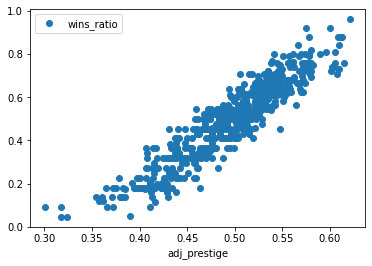

In [40]:
df_seasonal = combine_season_features(d_features)
ax = df_seasonal.plot(x='adj_prestige', y='wins_ratio', style='o')

In [41]:
prev_adj_prestiges = []
cur_adj_prestiges = []
cur_wins_ratios = []
it = iter(all_seasons)
prev_season = next(it)
prev_features = d_features[prev_season]
for cur_season in it:
    cur_features = d_features[cur_season]
    for team_features in cur_features.itertuples():
        team = team_features.team
        ind = prev_features.team == team
        if not any(ind):
            # Team has merged or changed name
            continue
        cur_wins_ratios.append(team_features.wins_ratio)
        cur_adj_prestiges.append(team_features.adj_prestige)
        prev_adj_prestige = prev_features.loc[ind, 'adj_prestige'].values[0]
        prev_adj_prestiges.append(prev_adj_prestige)
    prev_features = cur_features

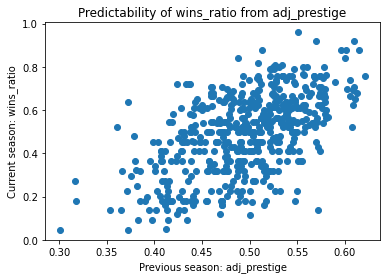

In [42]:
plt.plot(prev_adj_prestiges, cur_wins_ratios, 'o')
plt.title("Predictability of wins_ratio from adj_prestige")
plt.xlabel("Previous season: adj_prestige")
plt.ylabel("Current season: wins_ratio")
plt.show()

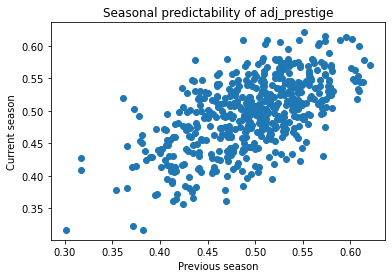

In [43]:
plt.plot(prev_adj_prestiges, cur_adj_prestiges, 'o')
plt.title("Seasonal predictability of adj_prestige")
plt.xlabel("Previous season")
plt.ylabel("Current season")
plt.show()

### Save the seasonal features

In [44]:
df_seasonal = combine_season_features(d_features)
df_seasonal.to_csv(os.path.join("..", "data", "seasonal_features.csv"), index=False)

## Intra-season statistics

In the [previous](#End-of-season-statistics "Section: End-of-season statistics")
section, we computed aggregated features for each team from all matches within a season.
In contrast, in this section we shall compute aggregated features from all matches in the same season
that are *prior* to each match of interest.

### Compute match features

For every match, we attempt to compute the features from within-season historical data prior to that match.
If there are no prior matches, then no match features are computed.

In [45]:
def compute_features(df_season_matches):
    """
    Computes all features for given set (or subset)
    of matches within the season.
    """
    df_features = init_team_features(df_season_matches)
    add_wins_features(df_features, df_season_matches)
    add_points_features(df_features, df_season_matches)
    add_rank_features(df_features)
    add_prestige_features(df_features, df_season_matches)
    return df_features

In [46]:
def get_prior_matches(df_season_matches, timestamp):
    """
    Obtains all matches in the current season prior to
    the given date-time.
    """
    return df_season_matches[df_season_matches.timestamp < timestamp]

In [47]:
df_intra_features = None
for season in all_seasons:
    df_season_matches = get_season_matches(df_matches, season)
    for match in df_season_matches.itertuples():
        df_prior_matches = get_prior_matches(df_season_matches, match.timestamp)
        if len(df_prior_matches) == 0:
            # First match in season - no features
            continue
        match_id = (match.datetime, match.round, match.venue)
        df_features = compute_features(df_prior_matches)
        for team in [match.for_team, match.against_team]:
            df_team = df_features[df_features.team == team]
            for features in df_team.itertuples(index=False):
                team_features = match_id + features
                if df_intra_features is None:
                    columns = ['datetime', 'round', 'venue'] + list(df_features.columns)
                    df_intra_features = pd.DataFrame(columns=columns)
                idx = len(df_intra_features)
                df_intra_features.loc[idx,:] = team_features

In [49]:
df_intra_features

,datetime,round,venue,season,team,teams,wins,draws,losses,wins_ratio,for,against,points_ratio,rank,rank_score,prestige,adj_prestige
0,Fri 06-Apr-1990 7:40 PM,R2,M.C.G.,1990,North Melbourne,14,0,0,1,0.0,89,142,0.385281,9,0.384615,0.0,0.0
1,Fri 06-Apr-1990 7:40 PM,R2,M.C.G.,1990,Richmond,14,0,0,1,0.0,74,133,0.357488,11,0.230769,0.357488,0.878539
2,Sat 07-Apr-1990 2:10 PM,R2,Princes Park,1990,Brisbane Bears,14,1,0,0,1.0,133,74,0.642512,4,0.769231,0.166808,0.722426
3,Sat 07-Apr-1990 2:10 PM,R2,Princes Park,1990,Fitzroy,14,0,0,1,0.0,60,141,0.298507,12,0.153846,-0.0,-0.0
4,Sat 07-Apr-1990 2:10 PM,R2,M.C.G.,1990,Geelong,14,0,0,1,0.0,77,192,0.286245,14,0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11790,Sun 17-Jul-2022 1:10 PM,R18,M.C.G.,2022,West Coast,18,2,0,14,0.125,1007,1786,0.360544,17,0.058824,0.031821,0.358452
11791,Sun 17-Jul-2022 2:50 PM,R18,Traeger Park,2022,Melbourne,18,12,0,4,0.75,1385,1038,0.571605,2,0.941176,0.070612,0.563625
11792,Sun 17-Jul-2022 2:50 PM,R18,Traeger Park,2022,Port Adelaide,18,8,0,8,0.5,1233,1135,0.520693,12,0.352941,0.057722,0.510135
11793,Sun 17-Jul-2022 4:40 PM,R18,Docklands,2022,Essendon,18,5,0,11,0.3125,1238,1503,0.45166,16,0.117647,0.046731,0.454557


### Save the data

In [50]:
df_intra_features.to_csv(os.path.join("..", "data", "prior_features.csv"), index=False)